<span style="font-familiy:Arial; font-weight:800; font-size:25px"> Compare standard DYCOMS simulations to Ackerman, et al. 2009 simulations </span>

# Setup notebook

## Load packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy.stats

In [2]:
savefigs = False

load_TS = True
load_profiles = True

In [3]:
# import own functions
from importnb import Notebook

with Notebook(): 
        import functions as fkts
        import namelist as nml
        from set_up_case_dict import *

## load Ackermann, et al. 2009 data
Note: loading data direclty using xarray does result in an MissingDimensionsError
<br> --> use netCDF4 insted  

The Ackerman et al. 2009 simulations include
* **11 modeling groups**
* **14 models** (tree groups with two model versions)
* simulations with and without **drizzle**
* simulations with and without **sedimentation**

The dimension named "drizzle" has a length of 2, with the first (second) 
element corresponding to drizzle being off (on).  Likewise, the first 
(second) element of the dimension named "sed" corresponds to cloud-water 
sedimentation being omitted (included).

see also https://www.giss.nasa.gov/staff/aackerman/gcss_rf02/dime/readme.txt


In [4]:
# select which cases with drizzle and sedimentation on 
idrizz = 1
ised = 1

In [5]:
dir_val_prof = '/home/jovyan/work/data/BLCWG_DYCOMS-II_RF02.profiles.nc'
dir_val_scal = '/home/jovyan/work/data/BLCWG_DYCOMS-II_RF02.scalars.nc'

### Load Scalars

In [6]:
nc = netCDF4.Dataset(dir_val_scal)


In [7]:
# get the names of the models
mods = []
for iname in nc["label"]:
    h = []
    [h.append(i.decode("utf-8")) for i in iname.data]
    mods.append("".join(h))
    
print("Model names:")
print(mods)    

Model names:
['COAMPS', 'COAMPS_SL', 'DHARMA', 'DHARMA_BO', 'MetO', 'MPI', 'NHM', 'RAMS', 'Reading', 'SAM', 'UCLA', 'UCLA_SB', 'Utah', 'WVU']


In [8]:
load_vars = [i for i in list(nc.variables) if len(nc.variables[i].shape) == 4]

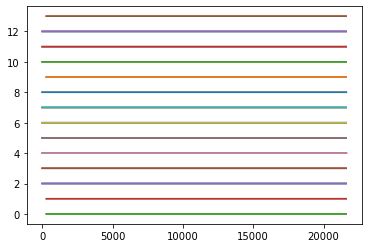

In [9]:
val_scal = {}
for idrizz in range(2):
    for ised in range(2):
        for imod in range(len(mods)):
            imod_dict = {}
            for ivar in load_vars:
                #print(ivar , nc.variables[ivar][imod][idrizz, ised].shape)
                idct = {ivar:np.ma.filled(nc.variables[ivar][imod][idrizz, ised][:],\
                                          fill_value = np.nan)}
                imod_dict.update(idct)

            val_scal.update({mods[imod]:imod_dict})
    
            #plt.plot(imod_dict["time"], imod_dict["lwp"], color = plt.cm.rainbow(idrizz+ised/4))
            plt.plot(imod_dict["time"], imod_dict["time"]*0+imod)

#### Import to xarray

In [10]:
all_vars = list(nc.variables)

["{0:s} = {1}".format(i, nc.variables[i].shape) for i in all_vars]

['label = (14, 9)',
 'missing = (14, 2, 2)',
 'ntime = (14, 2, 2)',
 'time = (14, 2, 2, 1873)',
 'zi = (14, 2, 2, 1873)',
 'zi_var = (14, 2, 2, 1873)',
 'zb = (14, 2, 2, 1873)',
 'zb_var = (14, 2, 2, 1873)',
 'cfrac = (14, 2, 2, 1873)',
 'lwp = (14, 2, 2, 1873)',
 'lwp_var = (14, 2, 2, 1873)',
 'tke = (14, 2, 2, 1873)',
 'w2_max = (14, 2, 2, 1873)',
 'wstar = (14, 2, 2, 1873)',
 'precip = (14, 2, 2, 1873)',
 'precip_var = (14, 2, 2, 1873)',
 'precip_max = (14, 2, 2, 1873)',
 'ndrop_cld = (14, 2, 2, 1873)']

In [11]:
load_var = [i for i in nc.variables if nc.variables[i].shape == (14, 2, 2, 1873)]

load_var

['time',
 'zi',
 'zi_var',
 'zb',
 'zb_var',
 'cfrac',
 'lwp',
 'lwp_var',
 'tke',
 'w2_max',
 'wstar',
 'precip',
 'precip_var',
 'precip_max',
 'ndrop_cld']

In [12]:
# create a helper dict
# initialize a data array with np.nan's
hdct = {i: (["model", "drizz", "sed", "ntime"],\
            np.ma.filled(nc.variables[i][:], fill_value=np.nan)) for i in load_var}

# put everything in a xr dataset
ntime = np.arange(nc.variables["time"].shape[-1])
AM09 = xr.Dataset(hdct,\
                coords ={"model":mods,\
                         "drizz":[0,1],\
                         "sed":[0,1],\
                         "ntime": ntime})

# Find min and max values for the Ackermann simulations

## Time series from individual models

The problem is that some (or all?) models have different time series with different dt spacing.

The problem is easiliy seen in this plot

In [13]:
AM09

<xarray.Dataset>
Dimensions:     (model: 14, drizz: 2, sed: 2, ntime: 1873)
Coordinates:
  * model       (model) <U9 'COAMPS' 'COAMPS_SL' 'DHARMA' ... 'Utah' 'WVU'
  * drizz       (drizz) int64 0 1
  * sed         (sed) int64 0 1
  * ntime       (ntime) int64 0 1 2 3 4 5 6 ... 1867 1868 1869 1870 1871 1872
Data variables: (12/15)
    time        (model, drizz, sed, ntime) float32 300.0 600.0 900.0 ... nan nan
    zi          (model, drizz, sed, ntime) float32 795.8 795.3 794.9 ... nan nan
    zi_var      (model, drizz, sed, ntime) float32 0.00247 0.004279 ... nan nan
    zb          (model, drizz, sed, ntime) float32 425.1 425.1 425.1 ... nan nan
    zb_var      (model, drizz, sed, ntime) float32 0.108 0.0 0.0 ... nan nan nan
    cfrac       (model, drizz, sed, ntime) float32 1.0 1.0 1.0 ... nan nan nan
    ...          ...
    w2_max      (model, drizz, sed, ntime) float32 0.0002228 0.0003942 ... nan
    wstar       (model, drizz, sed, ntime) float32 0.08685 0.08224 ... nan nan
    precip      (model, drizz, sed, ntime) float32 0.0 0.0 0.0 ... nan nan nan
    precip_var  (model, drizz, sed, ntime) float32 -0.0 -0.0 -0.0 ... nan nan
    precip_max  (model, drizz, sed, ntime) float32 0.0 0.0 0.0 ... nan nan nan
    ndrop_cld   (model, drizz, sed, ntime) float32 55.0 55.0 55.0 ... nan nan

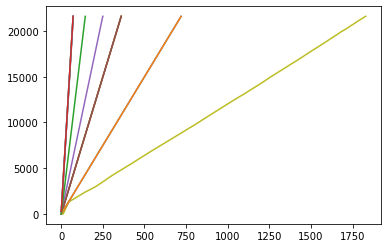

In [14]:
for imod in range(len(mods)):
    plt.plot(AM09["ntime"],\
             AM09["time"].sel(model = mods[imod], drizz = 0, sed = 0))

## Find min/max for a common time series 

In [15]:
# Create dict
dct_minmax  = {"driz0":{},\
               "driz1":{},}
for idict in list(dct_minmax):
    dct_minmax.update({idict:{"sed1":{}, "sed0":{}}})

The maximum time setp is 21600

The largest time step is 300

(both inderred manually)

In [16]:
# creat a common time axis
cm_time = np.arange(0, 21600, 300)

for idrizz in [0,1]:
    for ised in [0,1]:
        min_vals = pd.DataFrame(index=cm_time, columns=[
                                i for i in load_var if i != "time"], dtype=float)
        max_vals = pd.DataFrame(index=cm_time, columns=[
                                i for i in load_var if i != "time"], dtype=float)


        for ivar in [i for i in load_var if i != "time"]:
            # first item stays the same
            min_vals.loc[0, ivar] = float(AM09[ivar].sel(
                ntime=0,
                drizz=idrizz,
                sed=ised).min(dim="model").data)
            max_vals.loc[0, ivar] = float(AM09[ivar].sel(
                ntime=0,
                drizz=idrizz,
                sed=ised).max(dim="model").data)
            
            # loop though time steps
            for itime in range(1, len(cm_time)):
                
                # creat empty array 
                itime_minmax = np.zeros((len(mods), 2))*np.nan
                for imod in range(len(mods)):
                    # select model
                    smod = mods[imod]
                    
                    ## find time between t and t-1
                    # helper for model times
                    htime = AM09["time"].sel(model=smod, drizz=0, sed=0).data
                    # make all na times a big number
                    htime[np.where(np.isnan(htime))] = 99999999
                    # find the index
                    idx = np.where(
                        (htime >= cm_time[itime-1]) & (htime < cm_time[itime]))
                    
                    # when no times exist write nan
                    if len(idx[0]) == 0:
                        itime_minmax[imod, 0] = np.nan
                        itime_minmax[imod, 1] = np.nan
                    # else calculae min/max during time step
                    else:
                        itime_minmax[imod, 0] = np.nanmin(
                            AM09[ivar].sel(model=smod, drizz=idrizz, sed=ised)[idx])
                        itime_minmax[imod, 1] = np.nanmax(
                            AM09[ivar].sel(model=smod, drizz=idrizz, sed=ised)[idx])
                # calculate min/max for timestep over models
                min_vals.loc[cm_time[itime], ivar] = np.nanmin(itime_minmax[:, 0])
                max_vals.loc[cm_time[itime], ivar] = np.nanmax(itime_minmax[:, 0])
        # after looping though all times and variables update dict     
        hdict = dct_minmax["driz{}".format(idrizz)]["sed{}".format(ised)]
        hdict.update({"min":min_vals,\
                      "max":max_vals})

/tmp/ipykernel_2853/3475641775.py:47: RuntimeWarning: All-NaN axis encountered
  itime_minmax[imod, 0] = np.nanmin(
/tmp/ipykernel_2853/3475641775.py:49: RuntimeWarning: All-NaN axis encountered
  itime_minmax[imod, 1] = np.nanmax(
/tmp/ipykernel_2853/3475641775.py:47: RuntimeWarning: All-NaN axis encountered
  itime_minmax[imod, 0] = np.nanmin(
/tmp/ipykernel_2853/3475641775.py:49: RuntimeWarning: All-NaN axis encountered
  itime_minmax[imod, 1] = np.nanmax(
/tmp/ipykernel_2853/3475641775.py:47: RuntimeWarning: All-NaN axis encountered
  itime_minmax[imod, 0] = np.nanmin(
/tmp/ipykernel_2853/3475641775.py:49: RuntimeWarning: All-NaN axis encountered
  itime_minmax[imod, 1] = np.nanmax(
/tmp/ipykernel_2853/3475641775.py:47: RuntimeWarning: All-NaN axis encountered
  itime_minmax[imod, 0] = np.nanmin(
/tmp/ipykernel_2853/3475641775.py:49: RuntimeWarning: All-NaN axis encountered
  itime_minmax[imod, 1] = np.nanmax(
/tmp/ipykernel_2853/3475641775.py:47: RuntimeWarning: All-NaN axis encou

In [17]:
# check 
if False:
    plt.plot(dct_minmax["driz0"]["sed0"]["min"].index,
             dct_minmax["driz0"]["sed0"]["min"]["lwp"])
    plt.plot(dct_minmax["driz0"]["sed0"]["min"].index,
             dct_minmax["driz0"]["sed0"]["max"]["lwp"])

# Plot LWP over time

In [18]:
def def_fkt_fill_between(ax, idriz, ised, var, color):
    
    x = min_vals.index.values
    y1 = dct_minmax[idriz][ised]["min"][var]
    y2 =  dct_minmax[idriz][ised]["max"][var]
    
    ax[0].plot(x,y1,color = color, alpha = 0.1)
    ax[0].plot(x,y2,color = color, alpha = 0.1)
    
    label = "AM'09 Models".format(idriz, ised)
    ax[0].fill_between(x = x,\
                     y1 =  y1,\
                     y2 =  y2,\
                     alpha = 0.2,\
                     color = color,\
                     label = label,\
                     zorder = 1)
    
    ax[2].errorbar([label],\
                   y1.iloc[-1]+(y2.iloc[-1]-y1.iloc[-1])/2,\
                   yerr = (y2.iloc[-1]-y1.iloc[-1])/2,\
                   elinewidth=3, capsize=5, color = color)


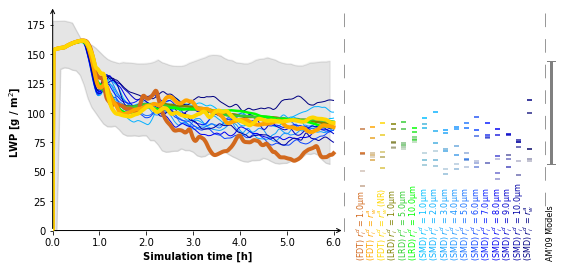

In [25]:
fig, ax = plt.subplots(1, 3, figsize=[9, 4],
                       gridspec_kw={'width_ratios': [3.5, 2.4, 0.1]})
plt.subplots_adjust(wspace=0.01)
# Add the Ackermann data
def_fkt_fill_between(ax=ax, idriz="driz1", ised="sed1",
                     var="lwp", color="grey")

if False:
    def_fkt_fill_between(ax=ax, idriz="driz0", ised="sed0",
                         var="lwp", color="orange")
    def_fkt_fill_between(ax=ax, idriz="driz1",
                         ised="sed0", var="lwp", color="red")
    def_fkt_fill_between(ax=ax, idriz="driz0", ised="sed1",
                         var="lwp", color="green")


# Add MIMICA data
lbl_col = []
for igrp in range(len(list(dct_all))):
    sgrp = list(dct_all)[igrp]
    for itype in range(len(list(dct_all[sgrp]))):
        stype = list(dct_all[sgrp])[itype]
        # loop over cases
        #l_cases = list(dct_all[sgrp][stype])
        #arg_cases = fkts.listargsort([fkts.fkt_getnum(i) for i in l_cases])
        #sl_cases = [l_cases[i] for i in arg_cases]
        
        for icase in range(len(dct_all[sgrp][stype])):
            scase = list(dct_all[sgrp][stype])[icase]
            dct_all[sgrp][stype][scase]
            iTS = fkts.fkt_load_TS(dct_all[sgrp][stype][scase]["dir_TS"])

            ax[1].scatter([dct_all[sgrp][stype][scase]["label"]],
                          iTS["LWP"].iloc[-1],
                          marker="_",
                          s=25,\
                          color=dct_all[sgrp][stype][scase]["color_drk"],
                          alpha = dct_all[sgrp][stype][scase]["alpha_up"])
            
            if (scase == "65e06"):
                ax[0].plot(iTS.index,
                           iTS["LWP"],
                           color= dct_all[sgrp][stype][scase]["color_drk"],\
                           alpha = dct_all[sgrp][stype][scase]["alpha_up"],
                           label= dct_all[sgrp][stype][scase]["label"],
                           linewidth=dct_all[sgrp][stype][scase]["lw"]/2,
                           zorder=dct_all[sgrp][stype][scase]["zord"])
                
        lbl_col.append(dct_all[sgrp][stype][scase]["color_drk"])

#ax[0].legend(loc="lower left",
#             bbox_to_anchor=(0, 1), ncol=3)
ax[0].set_ylabel("LWP [g / m$^2$]", fontweight = "bold")
ax[0].set_xlabel("Simulation time [h]", fontweight = "bold")
my_xticks = np.arange(0, 6.01*60*60, 60*60)
ax[0].set_xlim(0.2, 6.2*60*60+60)
ax[0].set_xticks(my_xticks)
ax[0].set_xticklabels(my_xticks/60/60)


for iax in ax:
    iax.spines['bottom'].set_position('zero')
    iax.set_ylim([0, 185])

for iax in [ax[1], ax[2]]:
    iax.tick_params(axis='x',labelsize = 8, labelrotation=90)
    [iax.spines[i].set_visible(False) for i in ["left", "top", "right", "bottom"]]
    iax.set_yticks([])
    xlim_raw = iax.get_xlim()
    iax.set_xlim(xlim_raw[0]-0.75, xlim_raw[1]+0.75)
    
    iax.tick_params(axis='x', direction='in',length = 0,  pad = 30)
    
    for tick in iax.get_xticklabels():
        tick.set_verticalalignment("bottom")
        tick.set_horizontalalignment("center")

# add arrow to y-axis
ax[0].spines["right"].set_visible(False)

# add arrow to y-axis
ax[0].annotate("", xy=(0, 0),
               xytext=(0, ax[0].get_ylim()[1]*1.03),
               arrowprops=dict(arrowstyle="<-"), clip_on = False, zorder = 100)

ax[0].annotate("", xy=(0, 0),
               xytext=(ax[0].get_xlim()[1] , 0),
               arrowprops=dict(arrowstyle="<-"), clip_on = False, zorder = 100)



ax[1].spines["right"].set_visible(True)

ax[0].spines["right"].set_visible(True)
ax[0].spines["left"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)


ax[0].spines["top"].set_visible(False)

ax[0].spines["right"].set_color("grey")
ax[0].spines["right"].set_linestyle((0,(16,16))) 
ax[1].spines["right"].set_color("grey")
ax[1].spines["right"].set_linestyle((0,(16,16))) 


for color,tick in zip(lbl_col,ax[1].xaxis.get_major_ticks()):

    tick.label1.set_color(color) #set the color property


if savefigs:
    plt.savefig(os.path.join(nml.dir_output, "AM09_LWP_validation.png"), dpi=600,
                bbox_inches="tight")
    